In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output

%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)

import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

In [3]:

df = pd.read_csv('trainquora.csv')
print('Shape of data is: ', df.shape)

Shape of data is:  (404290, 6)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [5]:
import warnings
warnings.filterwarnings('ignore')

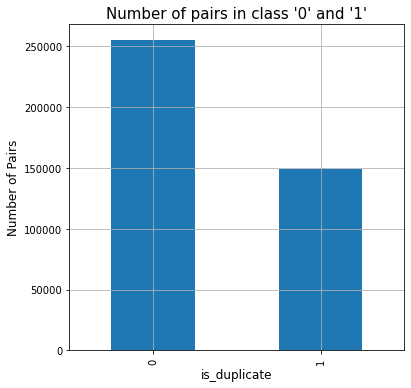

In [6]:
plt.figure(figsize = (6,6))
df.groupby("is_duplicate")['id'].count().plot.bar()
plt.title("Number of pairs in class '0' and '1'", fontsize = 15)
plt.xlabel('is_duplicate', fontsize = 12)
plt.ylabel('Number of Pairs', fontsize = 12)
plt.grid(1)
plt.show()

In [7]:
print('~> Total number of question pairs for training: {}'.format(len(df)))
print('\n~> Question pairs are not Similar (is_duplicate = 0): {}%\n i.e. {} data poins in dataset'
      .format(100 - round(df['is_duplicate'].mean()*100, 2), df[df['is_duplicate'] == 0].shape[0])) 
#using mean because we've class label as 0 or 1
print('\n~> Question pairs are Similar (is_duplicate = 1): {}%\ni.e. {} data points in dataset'
      .format(round(df['is_duplicate'].mean()*100, 2), df[df['is_duplicate'] == 1].shape[0]))

~> Total number of question pairs for training: 404290

~> Question pairs are not Similar (is_duplicate = 0): 63.08%
 i.e. 255027 data poins in dataset

~> Question pairs are Similar (is_duplicate = 1): 36.92%
i.e. 149263 data points in dataset


In [8]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}'.format(unique_qs))
print ('Number of unique questions that appear more than one time: {} ({}%)'
       .format(qs_morethan_onetime, round(qs_morethan_onetime/unique_qs*100,2)))
print ('Max number of times a single question is repeated: {}'.format(max(qids.value_counts())))

Total number of  Unique Questions are: 537933
Number of unique questions that appear more than one time: 111780 (20.78%)
Max number of times a single question is repeated: 157


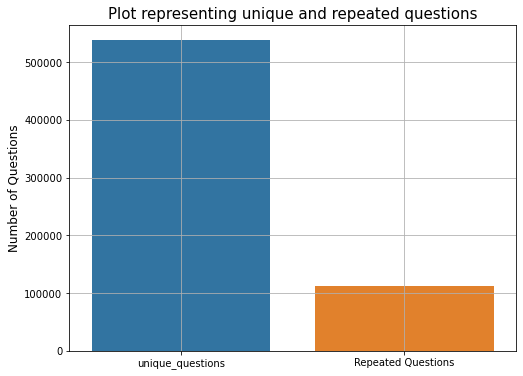

In [9]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(8, 6))
plt.title ("Plot representing unique and repeated questions", fontsize =15)
sns.barplot(x,y)
plt.ylabel('Number of Questions', fontsize = 12)
plt.grid(1)
plt.show()

In [10]:
print("Number of duplicate questions pairs", df.duplicated(['qid1', 'qid2']).sum())

Number of duplicate questions pairs 0


Maximum number of times a single question is repeated: 157



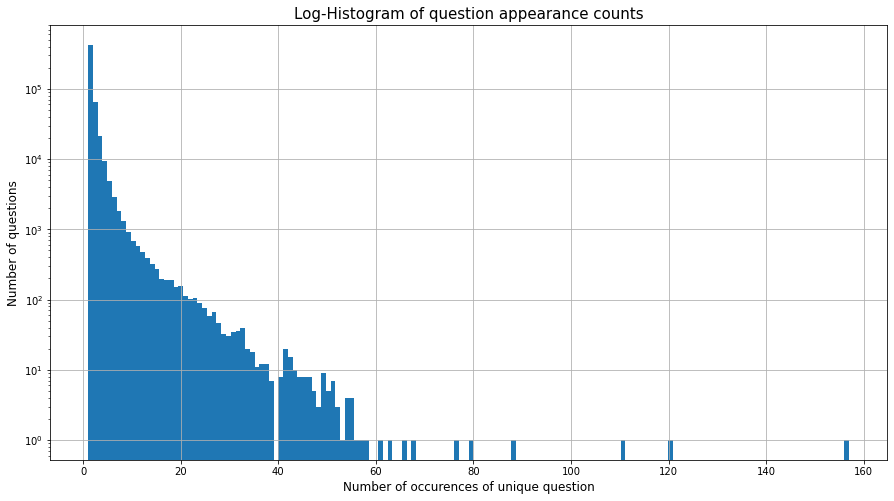

In [11]:
plt.figure(figsize=(15, 8))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts', fontsize = 15)
plt.xlabel('Number of occurences of unique question', fontsize = 12)
plt.ylabel('Number of questions', fontsize = 12)
plt.grid('on')
print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts())))

In [12]:
nan_rows = df[df.isnull().any(1)]
nan_rows

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [13]:
df.dropna(axis=0, how='any', inplace = True)
nan_rows = df[df.isnull().any(1)]
nan_rows.shape

(0, 6)

In [14]:
def basic_feature_extraction(row):
    x = [0]*9

    q1_len = len(row['question1'])
    q2_len = len(row['question2'])
    q1_n_word = len(row['question1'].split(" "))
    q2_n_word = len(row['question2'].split(" "))

    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))

    q1 = row['question1'].lower().replace('?','').replace('.','').replace('!','')
    q2 = row['question2'].lower().replace('?','').replace('.','').replace('!','')
    row_words = list(set(q1.split(' ') + q2.split(' '))) #unique words in both sentences
    q1_vec, q2_vec = np.zeros((1, len(row_words))), np.zeros((1, len(row_words)))

    for word in q1.split(' '):
        q1_vec[0][row_words.index(word)] += 1
    for word in q2.split(' '):
        q2_vec[0][row_words.index(word)] += 1

    x[0], x[1] = q1_len, q2_len
    x[2], x[3] = q1_n_word, q2_n_word
    x[4] = 1.0 * len(w1 & w2)
    x[5] = 1.0 * (len(w1) + len(w2))
    x[6] = 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    x[7] = np.linalg.norm(q1_vec-q2_vec) ## to find eucldian distance:https://stackoverflow.com/a/1401828
    x[8] = (1 - np.matmul(q1_vec, q2_vec.T)/(np.linalg.norm(q1_vec) * np.linalg.norm(q2_vec)))[0][0]
    return x

In [15]:
basic_features = df.apply(basic_feature_extraction, axis = 1)
basic_features_names = ['q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_Common', 
                        'word_total', 'word_share', 'dist_eucl', 'dist_cosine']
for i, name in enumerate(basic_features_names):
    df[name] = list(map(lambda x: x[i], basic_features))

cols = df.columns
print(df.shape)
df.head(2)

(404287, 15)


,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_total,word_share,dist_eucl,dist_cosine
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,14,12,10.0,23.0,0.434783,1.414214,0.055089
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,8,13,4.0,20.0,0.200000,3.316625,0.452277


In [16]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))
print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 66
Number of Questions with minimum length [question2] : 22


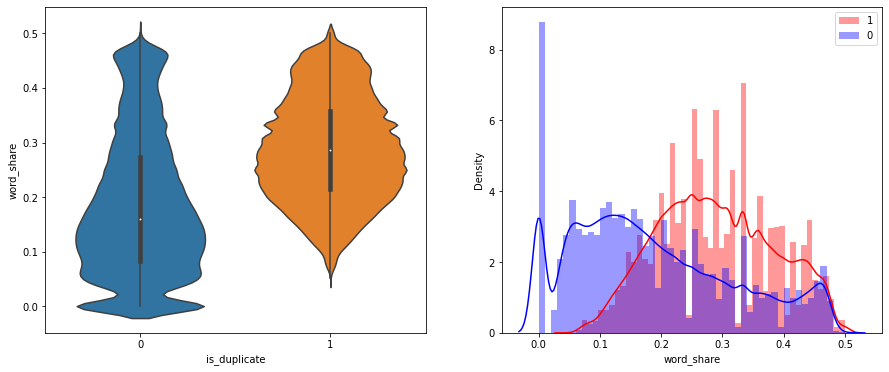

In [17]:
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(1,2,1)
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

ax2 = fig.add_subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue')
ax2.legend()
plt.show()

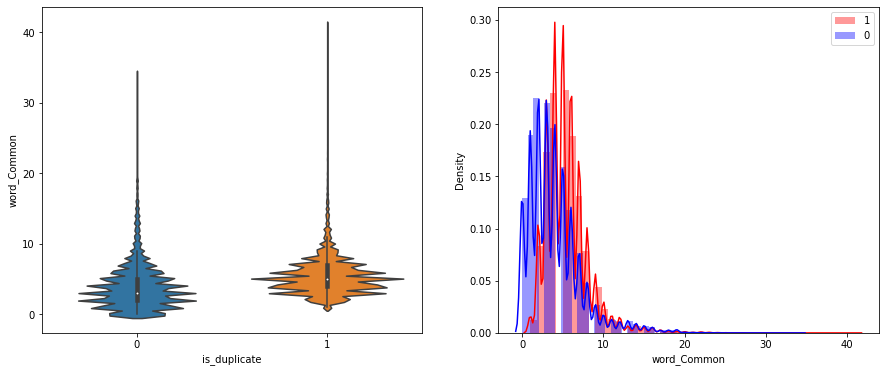

In [18]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

ax2 = fig.add_subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue')
ax2.legend()
plt.show()

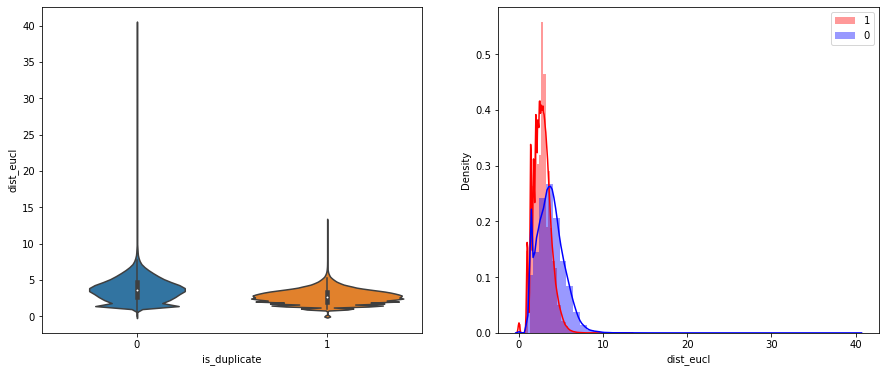

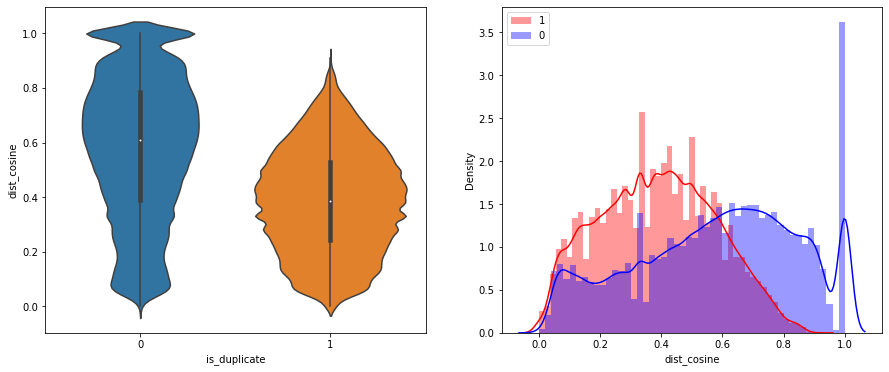

In [19]:
for i in ['dist_eucl', 'dist_cosine']:
    fig = plt.figure(figsize=(15,6))
    ax1 = fig.add_subplot(1,2,1)
    sns.violinplot(x = 'is_duplicate', y = i, data = df[0:])

    ax2 = fig.add_subplot(1,2,2)
    sns.distplot(df[df['is_duplicate'] == 1.0][i][0:] , label = "1", color = 'red')
    sns.distplot(df[df['is_duplicate'] == 0.0][i][0:] , label = "0" , color = 'blue')
    ax2.legend()
    plt.show()

In [20]:

import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

In [21]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ankit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
def text_preprocess(x):
    porter = PorterStemmer()
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x) #e.g. replace 12000000 with 12m
    x = re.sub(r"([0-9]+)000", r"\1k", x) #e.g. replace 52000 with 52k
    x = re.sub(r'<.*?>', '',x) # removes the htmltags: https://stackoverflow.com/a/12982689
    # stemming the words
    x = porter.stem(x)
    return x

In [25]:
SAFE_DIV = 0.0001
STOP_WORDS = stopwords.words("english")

def get_token_features(q1, q2):
    token_features = [0.0]*10
    # Converting the Sentence into Tokens:
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])

    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])

    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))

    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2

    return token_features

# get the Longest Common sub string
def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    print('1. Extracting Basic Features...')
    basic_features = df.apply(basic_feature_extraction, axis = 1)
    basic_features_names = ['q1len', 'q2len', 'q1_n_word', 'q2_n_word', 'word_Common', 'word_total', 'word_share', 'dist_eucl', 'dist_cosine']
    for i, name in enumerate(basic_features_names):
        df[name] = list(map(lambda x: x[i], basic_features))
        
    # preprocessing each question
    print('2. Extracting Advance Features\n', '2.1 Text preprocessing')
    df["question1"] = df["question1"].apply(text_preprocess)
    df["question2"] = df["question2"].apply(text_preprocess)

    # Merging Features with dataset
    print("2.2 Extracting token features...")
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    new_columns = ["cwc_min", "cwc_max", "csc_min" ,"csc_max" ,"ctc_min","ctc_max","last_word_eq" ,"first_word_eq" ,"abs_len_diff","mean_len"]
    for i, name in enumerate(new_columns):
        df[name] = list(map(lambda x: x[i], token_features))
        
        
        print('2. Extracting Advance Features\n', '2.1 Text preprocessing')
    df["question1"] = df["question1"].apply(text_preprocess)
    df["question2"] = df["question2"].apply(text_preprocess)

    # Merging Features with dataset
    print("2.2 Extracting token features...")
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    new_columns = ["cwc_min", "cwc_max", "csc_min" ,"csc_max" ,"ctc_min","ctc_max","last_word_eq" ,"first_word_eq" ,"abs_len_diff","mean_len"]
    for i, name in enumerate(new_columns):
        df[name] = list(map(lambda x: x[i], token_features))

    #Computing Fuzzy Features and Merging with Dataset
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("2.3 Extracting Fuzzy Features...")
    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)

    return df

In [27]:
if os.path.isfile('extracted_features.csv'):
    df = pd.read_csv('extracted_features.csv', encoding = 'latin-1')
    print("Shape of Extracted Features is: ", df.shape)
else:
    df = pd.read_csv('trainquora.csv')
    df.dropna(axis = 0, how = 'any', inplace = True)
    df = extract_features(df)
    df.to_csv('extracted_features.csv', index = False)
    print('After Extraction shape of data is: ', df.shape)

print('shape of data is: ', df.shape)
df.head(2)

1. Extracting Basic Features...
2. Extracting Advance Features
 2.1 Text preprocessing
2.2 Extracting token features...
2. Extracting Advance Features
 2.1 Text preprocessing
2. Extracting Advance Features
 2.1 Text preprocessing
2. Extracting Advance Features
 2.1 Text preprocessing
2. Extracting Advance Features
 2.1 Text preprocessing
2. Extracting Advance Features
 2.1 Text preprocessing
2. Extracting Advance Features
 2.1 Text preprocessing
2. Extracting Advance Features
 2.1 Text preprocessing
2. Extracting Advance Features
 2.1 Text preprocessing
2. Extracting Advance Features
 2.1 Text preprocessing
2. Extracting Advance Features
 2.1 Text preprocessing
2.2 Extracting token features...
2.3 Extracting Fuzzy Features...
After Extraction shape of data is:  (404287, 30)
shape of data is:  (404287, 30)


,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1_n_word,q2_n_word,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,66,57,14,12,...,0.714281,0,1,2,13.0,100,93,93,98,0.965517
1,1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0,51,88,8,13,...,0.307690,0,1,5,10.5,86,63,66,75,0.576923


In [28]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#chnaging flattened array into string using .join()
p = ' '.join(p)
n = ' '.join(n)

print ("Total lenght of string in duplicate pair questions after merging into one big string:",len(p))
print ("Total lenght of string in non duplicate pair questions after merging into one big string :",len(n))

#adding some words in stopwords and removing some words from stopwords
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")
stopwords.remove("no")
stopwords.remove("like")

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510048
Total lenght of string in duplicate pair questions after merging into one big string: 16109858
Total lenght of string in non duplicate pair questions after merging into one big string : 33192320


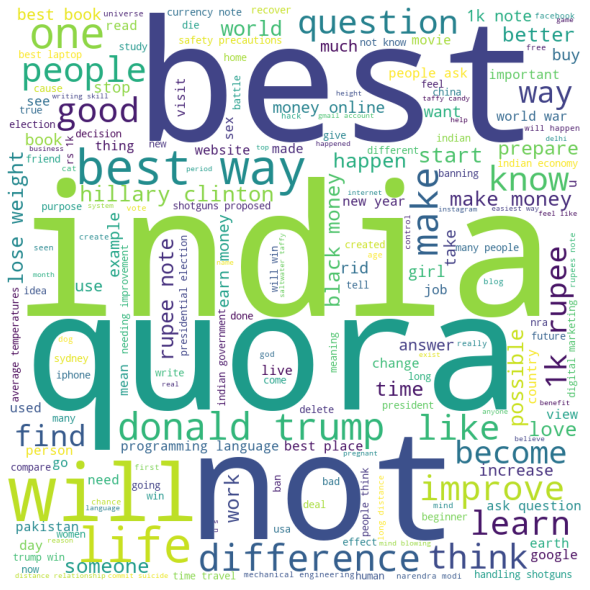

In [29]:
from wordcloud import WordCloud
    
wordcloud = WordCloud(width = 800, height = 800,
                      background_color ='white',
                      stopwords = stopwords,
                      min_font_size = 10).generate(p)
# plot the WordCloud image
plt.figure(figsize = (12, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

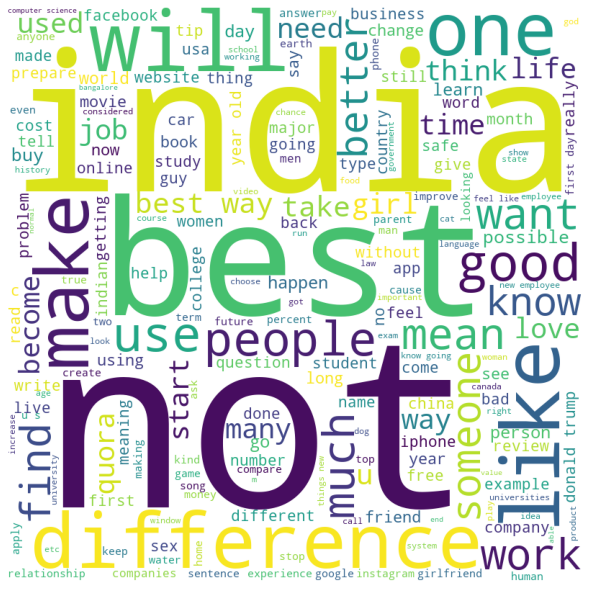

In [30]:
from wordcloud import WordCloud
    
wordcloud = WordCloud(width = 800, height = 800,
                      background_color ='white',
                      stopwords = stopwords,
                      min_font_size = 10).generate(n)
# plot the WordCloud image
plt.figure(figsize = (12, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

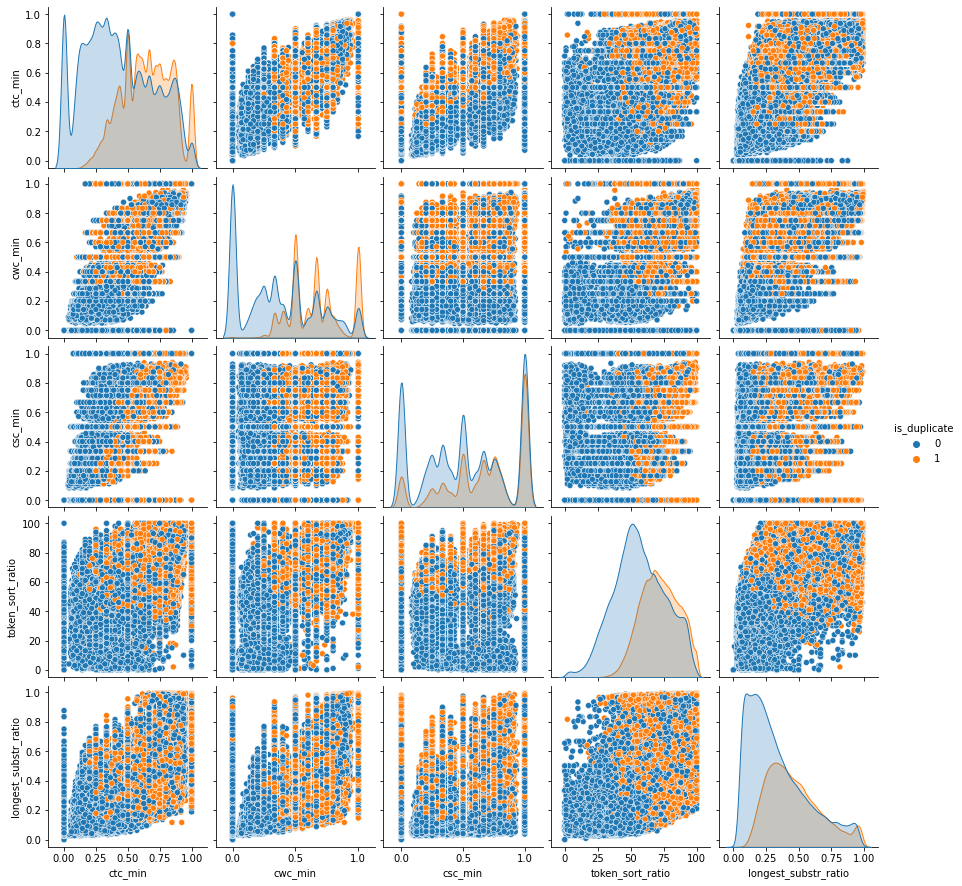

In [31]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'longest_substr_ratio','is_duplicate']][0:n], hue='is_duplicate',
             vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'longest_substr_ratio'])
plt.show()

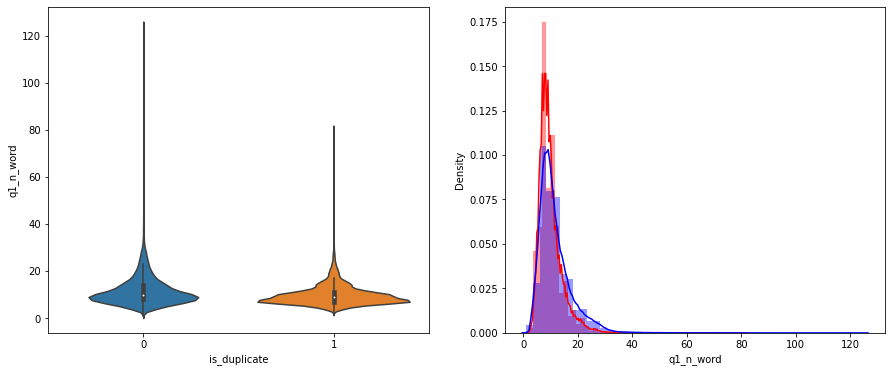

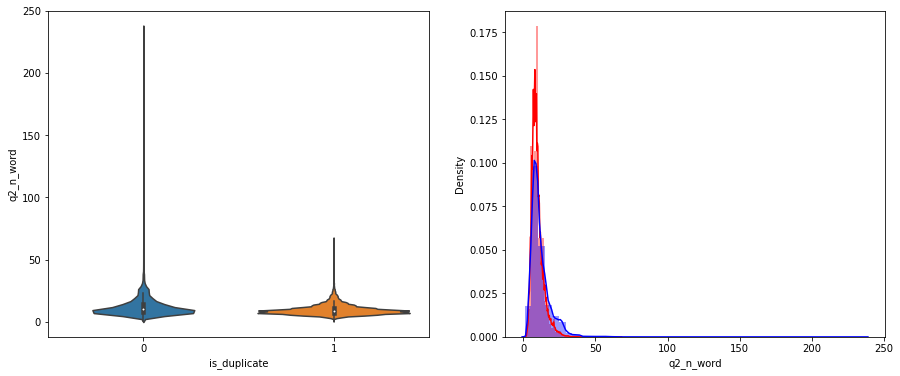

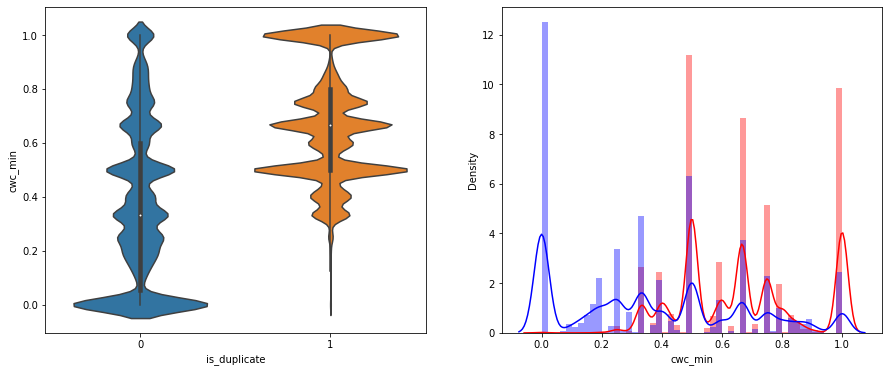

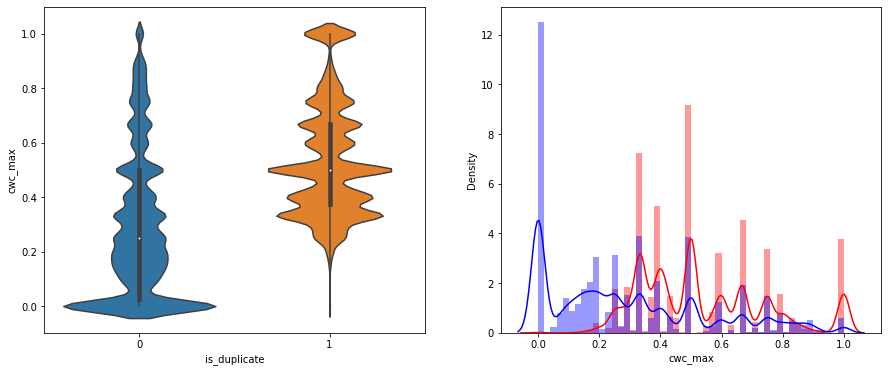

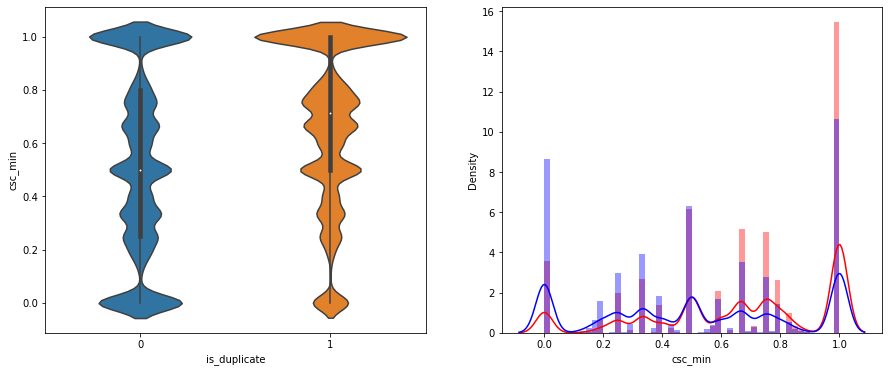

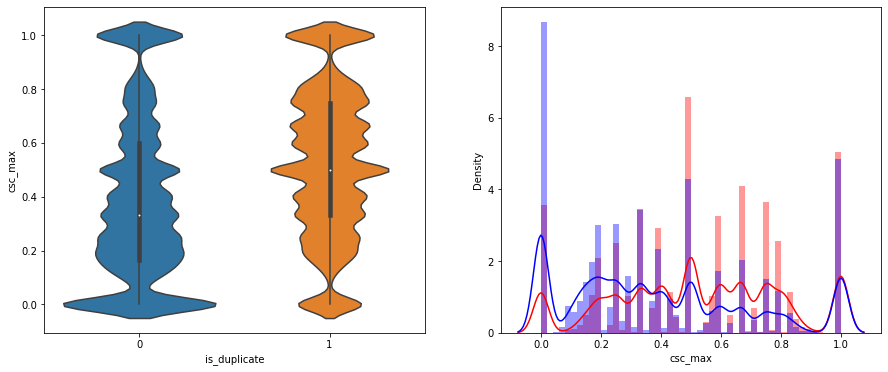

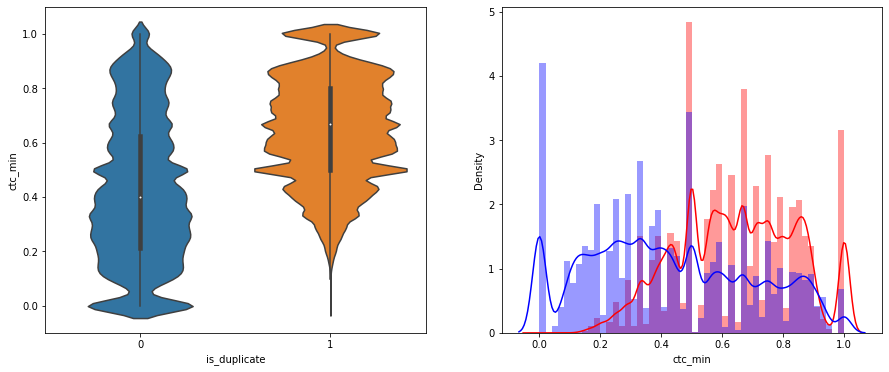

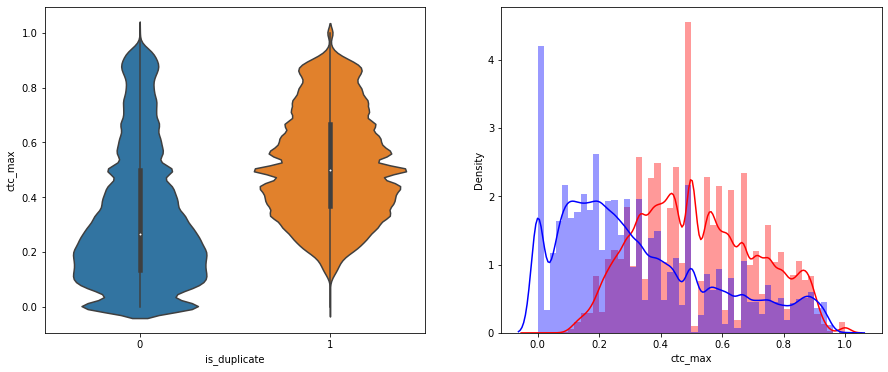

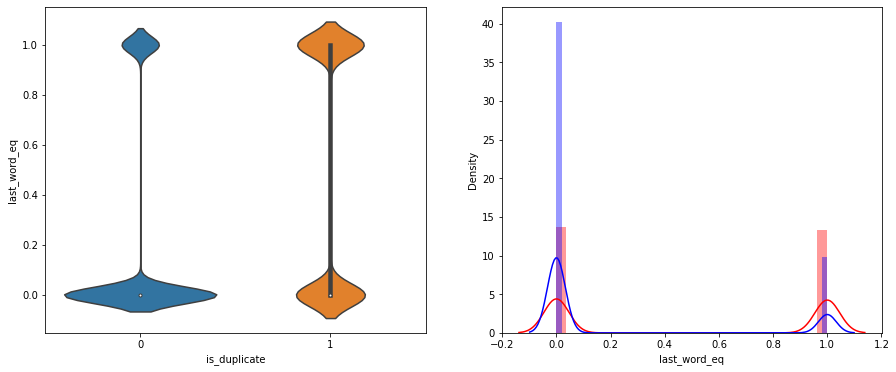

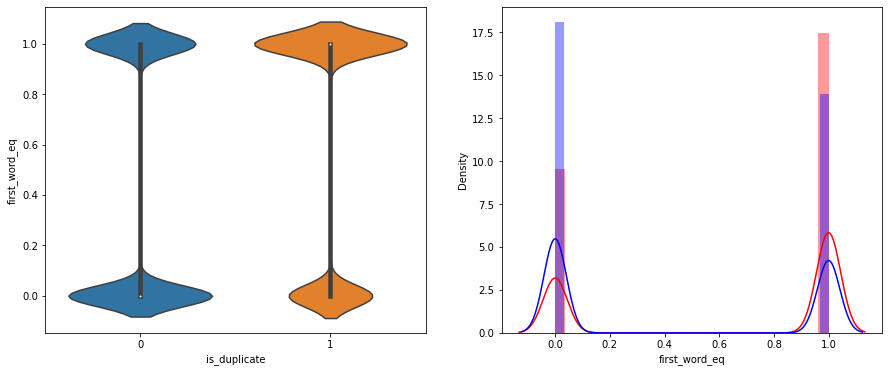

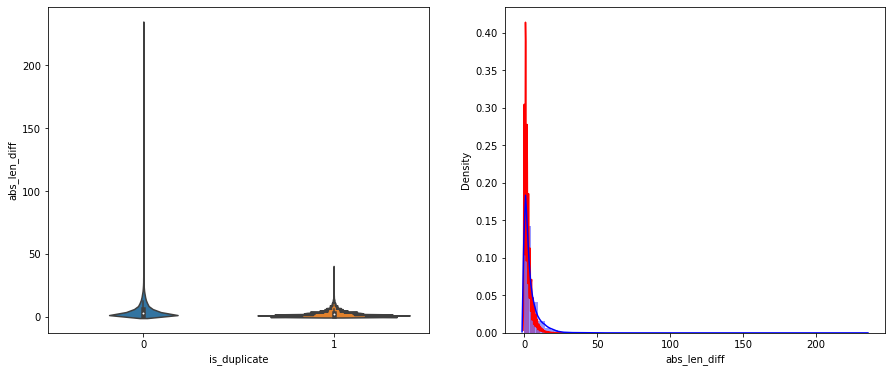

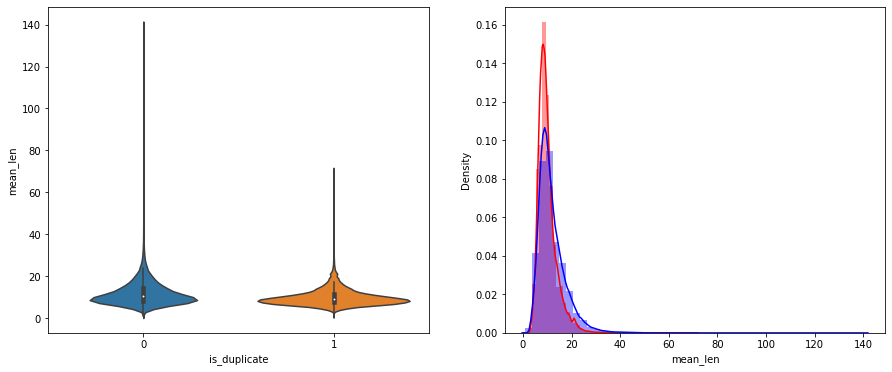

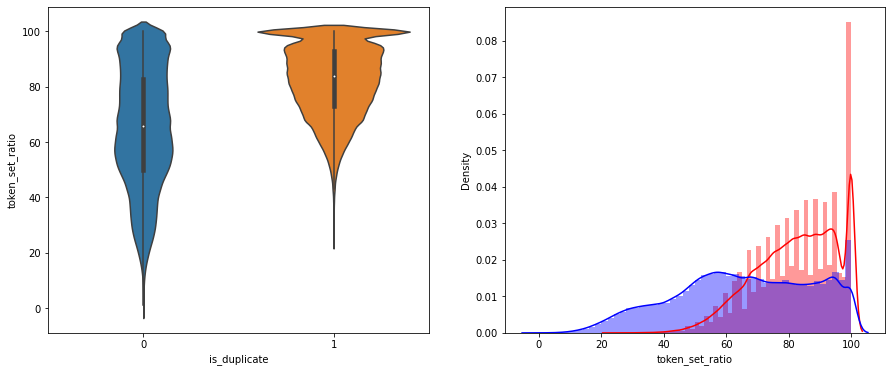

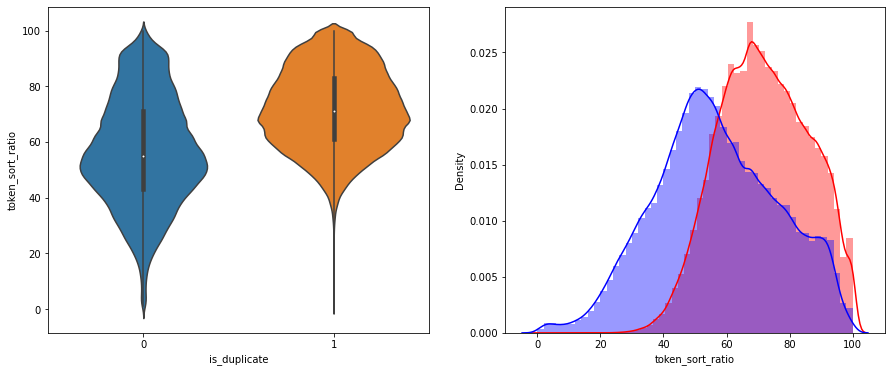

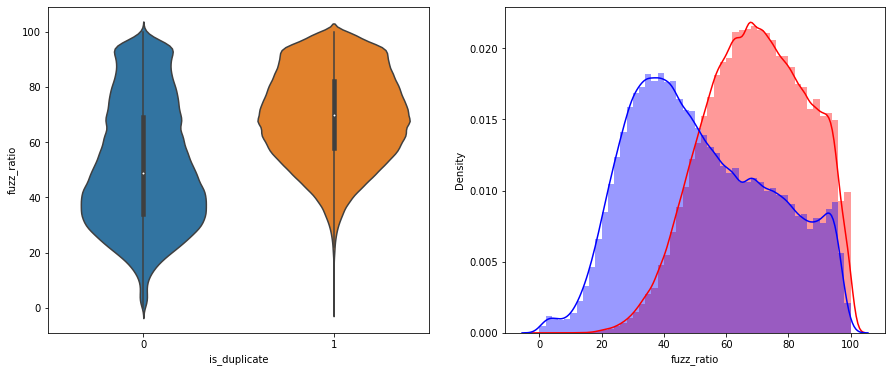

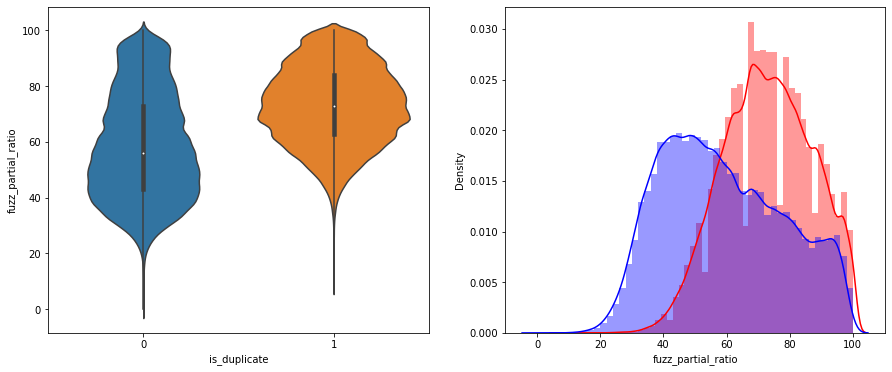

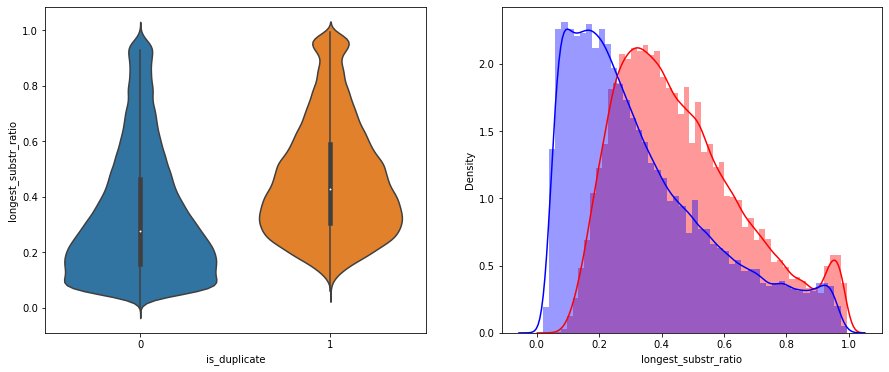

In [32]:
cols = [col for col in df.columns if col not in cols]
for col in cols:
    # Distribution of the token_sort_ratio
    plt.figure(figsize=(15, 6))

    plt.subplot(1,2,1)
    sns.violinplot(x = 'is_duplicate', y = col, data = df[0:] , )

    plt.subplot(1,2,2)
    sns.distplot(df[df['is_duplicate'] == 1.0][col][0:] , label = "1", color = 'red')
    sns.distplot(df[df['is_duplicate'] == 0.0][col][0:] , label = "0" , color = 'blue' )
    plt.show()

In [33]:
from sklearn.preprocessing import MinMaxScaler
dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

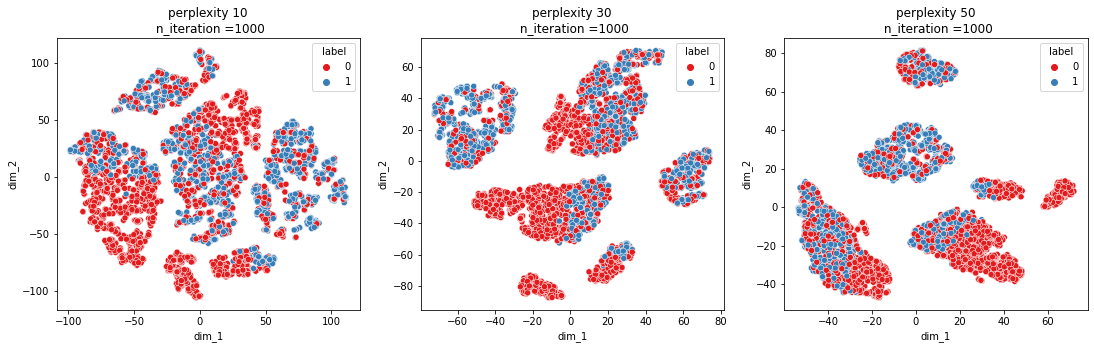

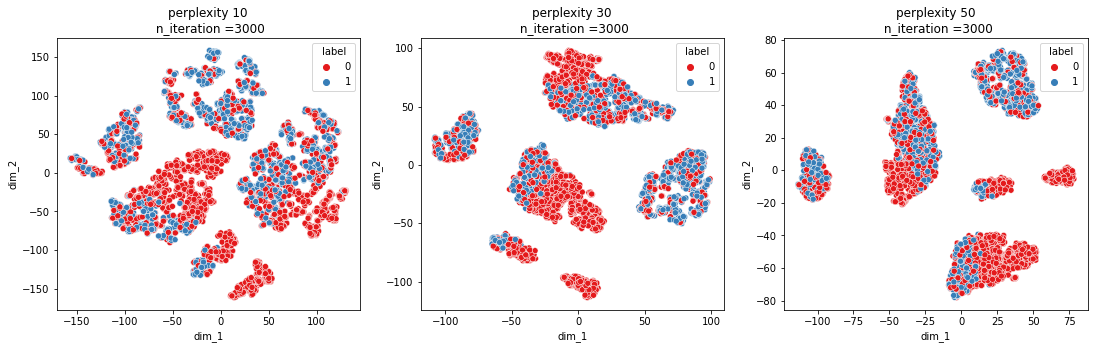

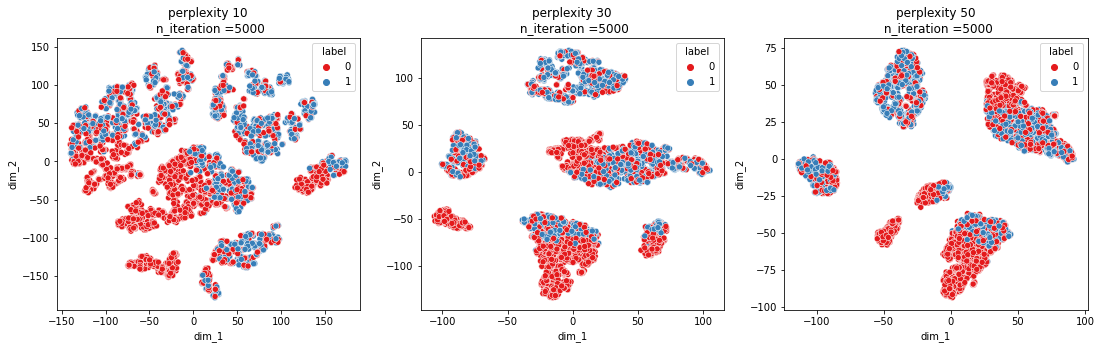

In [34]:
def TSNE_data(p,n):
    tsne = TSNE(n_components=2, perplexity = p,  n_iter= n).fit_transform(X)
    #https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html
    df = pd.DataFrame({'dim_1':tsne[:,0], 'dim_2':tsne[:,1] ,'label':y})
    return df
  
iterations = [1000, 3000, 5000]
perplexities = [10, 30, 50]

for n in iterations:
    fig = plt.figure(figsize=(25,5))
    for i, p in enumerate(perplexities):
        data = TSNE_data(p,n)
        ax = fig.add_subplot(1,4,i+1)
#         https://seaborn.pydata.org/generated/seaborn.scatterplot.html
        ax = sns.scatterplot(data=data, x='dim_1', y='dim_2', hue='label', palette="Set1",markers=['s','o'])
        plt.title('perplexity {}\n n_iteration ={}'.format(p,n))
